Adjusted Finance – Keroshan Pillay, 2024

# Preparation

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display, Math
from enum import Enum

# Ensure plots display inline in Jupyter
%matplotlib inline

# Data Loading and Preprocessing

We will use price data from various assets collected from Chainlink oracles on Ethereum. The data collection process is outside the scope of this notebook. We expect to have daily data for each asset.

First, let's load the data.

In [2]:
# Load data
data = pd.read_csv('test-data/8-asset.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.set_index('timestamp', inplace=True)

# Since our data extends into future dates (e.g., 2024), we'll select a specific period for analysis
# Adjust the date range as per your dataset
data = data.loc['2024-03-01':'2024-04-01']
data.head()


,ETH,BTC,BNB,LINK,UNI,AAVE,MKR,AVAX
timestamp,,,,,,,,
2024-03-01,3441.610000,62131.367003,412.477208,21.259645,12.435090,113.606744,2121.841551,43.333850
2024-03-02,3416.290000,61902.137452,412.440540,20.980529,12.546040,114.549176,2112.055300,43.314242
2024-03-03,3473.590479,63693.650000,415.442950,20.232239,12.412077,111.099000,2083.378519,42.368560
2024-03-04,3713.881230,67419.727824,424.502347,20.885050,13.069126,117.101990,2190.093359,43.092124
2024-03-05,3752.440000,65802.740410,402.737475,19.440370,14.738980,111.663745,2051.908000,40.010620


If you wish to include a risk-free asset, such as a Treasury Bill yielding a certain annual percentage yield (APY), you can add it to the dataset. Here, we add a Treasury Bill with a 5% APY.

__*NOTE: THIS BREAKS STANDARD MPT*__

The improvements by Keroshan Pillay, 2024, specifically look at fixing this phenoomenon, 

In [36]:
# # Add a Treasury Bill yielding 5% APY
# # Convert 5% APY to daily returns (assuming 252 trading days)
# daily_yield = (1 + 0.05) ** (1/252) - 1

# # Create a treasury series that starts at 100 and grows at the daily rate
# treasury_series = 100 * np.cumprod([1 + daily_yield] * len(data))

# # Add the Treasury series to the dataframe
# data['USD'] = treasury_series

# # Verify the annual yield is approximately 5%
# annual_return = (treasury_series[-1] / treasury_series[0]) - 1
# print(f"Annualized Treasury yield: {annual_return:.2%}")

# data.head()


# Observation

## Calculating Expected Returns

From the data, we need to form beliefs about what the future might be. To do this, we will use the historical mean daily returns as our expected returns. We also calculate the covariance matrix to understand the risk associated with the assets and how they correlate with each other.

In [7]:
# Calculate daily percentage changes
pct_change = data.pct_change().dropna()

# Calculate expected returns (mean daily returns)
beliefs = pct_change.mean()

# Calculate the covariance matrix
cov_matrix = pct_change.cov()

beliefs


ETH     0.001885
BTC     0.004435
BNB     0.012858
LINK   -0.003755
UNI     0.001420
AAVE    0.004353
MKR     0.021044
AVAX    0.008145
dtype: float64

We believe asset X to return belief[X] tomorrow

## Variance

Now, we need to estimate the risk we are taking on with any of these assets. This is the variance of the set. We need to do this for every asset in the basket; but, importantly, we need to determine correlated risk – the covariance matrix

In [8]:
cov_matrix = pct_change.cov()
cov_matrix

,ETH,BTC,BNB,LINK,UNI,AAVE,MKR,AVAX
ETH,0.001830,0.001432,0.001311,0.001223,0.001768,0.001549,0.000939,0.001805
BTC,0.001432,0.001280,0.001243,0.001065,0.001204,0.001254,0.000862,0.001683
BNB,0.001311,0.001243,0.002777,0.001449,0.001127,0.001761,0.001676,0.002059
LINK,0.001223,0.001065,0.001449,0.001744,0.001200,0.001741,0.001447,0.001431
UNI,0.001768,0.001204,0.001127,0.001200,0.002666,0.001702,0.000795,0.001482
AAVE,0.001549,0.001254,0.001761,0.001741,0.001702,0.002813,0.001494,0.002415
MKR,0.000939,0.000862,0.001676,0.001447,0.000795,0.001494,0.002738,0.001243
AVAX,0.001805,0.001683,0.002059,0.001431,0.001482,0.002415,0.001243,0.004685


Covariance, as typically defined, can be computed as

In [42]:
display(Math(r'\sigma_{12} = \rho_{12} \sigma_1 \sigma_2'))

<IPython.core.display.Math object>

# Weights

Once we have our observations about the world converted to beliefs, we are in a position to determine the weighting of the basket. A given set of weights is going to result in some expected return and corresponding variance. 

## Weights -> Value

Given some weights, we should be able to calculate the return and volatility of a given portfolio. The math is left as an exercise to the reader :)

In [13]:
def portfolio_return(weights, beliefs):
    '''
    Calculate the expected return for a given set of weights
    '''
    return np.sum(weights * beliefs)

def portfolio_volatility(weights, cov_matrix):
    '''
    Calculate the volatility for a given set of weights
    '''
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

As an example, we can generate some random weights and see how they perform, based on our beliefs and observations

In [14]:
def generate_random_weights(num_assets):
    '''
    Generate random weights that sum to 1
    '''
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)
    return weights

random_weights = generate_random_weights(len(beliefs))
expected_return = portfolio_return(random_weights, beliefs)
volatility = portfolio_volatility(random_weights, cov_matrix)

print(f'Random Weights: {random_weights}')
print(f'Expected Return: {expected_return:.4f}')
print(f'Volatility: {volatility:.4f}')


Random Weights: [0.15027987 0.0320182  0.26928467 0.06429671 0.02837801 0.2224132
 0.2155711  0.01775825]
Expected Return: 0.0093
Volatility: 0.0413


### Finding the Optimimum weights

So, we can see how random weights perform. However, what are the _optimal_ weights here? That depends on what you think of as optimal. We don't just care about returns, we also care about variance and the dependence on these is non-linear. To find the optimum, we must define what is optimum. Thus, we define a *utility function*

Let's take our core utility function to be the logarithmic one, which is presented by Markowitz in his 1959 work.

In [46]:
display(Math(r'U(R) = \log(1+R)'))

<IPython.core.display.Math object>

In his Nobel lecture, Markowitz identified a specific approximation of the utility function that performed exceptionally well in his and Haim Levy's work. The function he highlighted as doing best "almost without exception" is:

In [47]:
display(Math(r'f(E, V) = U(E) + 0.5U"(E)V'))

<IPython.core.display.Math object>

Applying this to logarithmic utility,

In [48]:
display(Math(r'f(E, V) = \log(1 + E) - \frac{0.5V}{(1 + E)^2}'))

<IPython.core.display.Math object>

We have compiled a list of common utility functions, expressed as Taylor approximations below.

In [10]:
class UtilityType(Enum):
    LOG = "log"
    QUADRATIC = "quadratic"
    EXPONENTIAL = "exponential"
    POWER = "power"
    LINEAR = "linear"
    HYPERBOLIC = "hyperbolic"

def utility_function(expected_return, volatility, utility_type=UtilityType.QUADRATIC, risk_aversion=2):
    """
    Calculate utility using various utility functions based on Markowitz's second-order Taylor approximation.
    
    Parameters:
    -----------
    expected_return : float
        Expected return (E)
    volatility : float
        Variance of returns (V)
    utility_type : UtilityType
        Type of utility function to use
    risk_aversion : float
        Risk aversion coefficient (lambda)
        
    Returns:
    --------
    float
        Utility value based on the selected function
    """
    
    if utility_type == UtilityType.LOG:
        # Log utility: log(1+E) - 0.5V/(1+E)^2
        return np.log(1 + expected_return) - 0.5 * volatility / (1 + expected_return)**2
    
    elif utility_type == UtilityType.QUADRATIC:
        # Quadratic utility: E - (λ/2)E^2 - (λ/2)V
        return (expected_return - 
                (risk_aversion/2) * expected_return**2 - 
                (risk_aversion/2) * volatility)
    
    elif utility_type == UtilityType.EXPONENTIAL:
        # Exponential utility: -e^(-λE) - (λ^2/2)e^(-λE)V
        return (-np.exp(-risk_aversion * expected_return) - 
                (risk_aversion**2/2) * np.exp(-risk_aversion * expected_return) * volatility)
    
    elif utility_type == UtilityType.POWER:
        # Handle the special case when risk_aversion == 1 (log utility)
        if risk_aversion == 1:
            adjusted_return = 1 + expected_return
            if adjusted_return <= 0:
                return float('-inf')
            return np.log(adjusted_return) - 0.5 * volatility / (adjusted_return ** 2)
        else:
            adjusted_return = 1 + expected_return
            if adjusted_return <= 0:
                return float('-inf')
            first_term = (adjusted_return ** (1 - risk_aversion)) / (1 - risk_aversion)
            second_term = 0.5 * risk_aversion * volatility / (adjusted_return ** (risk_aversion + 1))
            return first_term - second_term


    
    else:
        raise ValueError("Invalid utility type specified")

So, we can now figure out the utility for any given expected return and volatility. Let's do this for a random weight choice.

In [16]:
# Generate random weights
random_weights = generate_random_weights(len(beliefs))

# Calculate expected return and volatility
expected_return = portfolio_return(random_weights, beliefs)
volatility = portfolio_volatility(random_weights, cov_matrix)

# Calculate utility
utility = utility_function(expected_return, volatility)

print(f'Utility: {utility:.4f}')


Utility: -0.0355


We can now use numerical methods to find our optimimum weights.

In [17]:
from scipy.optimize import minimize
import numpy as np

def optimize_portfolio(beliefs, cov_matrix):
    num_assets = len(beliefs)
    
    # Objective function to maximize (we'll minimize its negative)
    def objective(weights):
        expected_return = portfolio_return(weights, beliefs)
        volatility = portfolio_volatility(weights, cov_matrix)
        return -utility_function(expected_return, volatility)  # Negative because we want to maximize
    
    # Constraint: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds: each weight between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Initial guess: equal weights
    initial_weights = np.array([1.0/num_assets] * num_assets)
    
    # Optimize
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        optimized_weights = result.x
        expected_return = portfolio_return(optimized_weights, beliefs)
        volatility = portfolio_volatility(optimized_weights, cov_matrix)
        utility = utility_function(expected_return, volatility)
        return optimized_weights, expected_return, volatility, utility
    else:
        raise ValueError("Optimization failed.")

# Usage
optimized_weights, optimal_expected_return, optimal_volatility, optimal_utility = optimize_portfolio(beliefs, cov_matrix)

print("Optimized Weights:")
for asset, weight in zip(beliefs.index, optimized_weights):
    print(f"{asset}: {weight:.4f}")
print(f"\nExpected Return: {optimal_expected_return:.4f}")
print(f"Volatility: {optimal_volatility:.4f}")
print(f"Utility: {optimal_utility:.4f}")

Optimized Weights:
ETH: 0.0000
BTC: 0.5571
BNB: 0.0000
LINK: 0.0000
UNI: 0.0000
AAVE: 0.0000
MKR: 0.4429
AVAX: 0.0000

Expected Return: 0.0118
Volatility: 0.0369
Utility: -0.0252


Markowitz posits that we can choose a few weights that will end up on the 'efficient frontier'. This frontier optimizes for expected return / volatility. In other words, for a given volatility, the frontier shows the best return possible (predicted). There are many ways to visualize the frontier, and it is sometimes possible to just guess random weights and the frontier will appear.

However, we prefer rigor. As such, let's look for all 'efficient' portfolios that provide the minimum volatility for a given return.

In [18]:
# Define a range of target expected returns
min_return = beliefs.min()
max_return = beliefs.max()
target_returns = np.linspace(min_return, max_return, 1000)

# Lists to store the results
efficient_portfolios = []
frontier_returns = []
frontier_volatilities = []

num_assets = len(beliefs)

# Loop over target returns to compute the efficient frontier
for target_return in target_returns:
    # Objective function: portfolio variance
    def portfolio_variance(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Constraints
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, beliefs) - target_return}  # Target return
    )
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Initial guess: optimized weights from previous step or equal weights
    initial_weights = optimized_weights  # Or use np.array([1.0/num_assets]*num_assets)
    
    # Optimize
    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        variance = portfolio_variance(weights)
        vol = np.sqrt(variance)
        ret = portfolio_return(weights, beliefs)
        
        frontier_returns.append(ret)
        frontier_volatilities.append(vol)
        efficient_portfolios.append(weights)
    else:
        print(f"Optimization failed for target return: {target_return}")


/var/folders/5m/h65pmmz91p78cnrgg_0v5v5c0000gn/T/ipykernel_20724/806050514.py:14: RuntimeWarning: invalid value encountered in divide
  perturbed_weights /= np.sum(perturbed_weights)


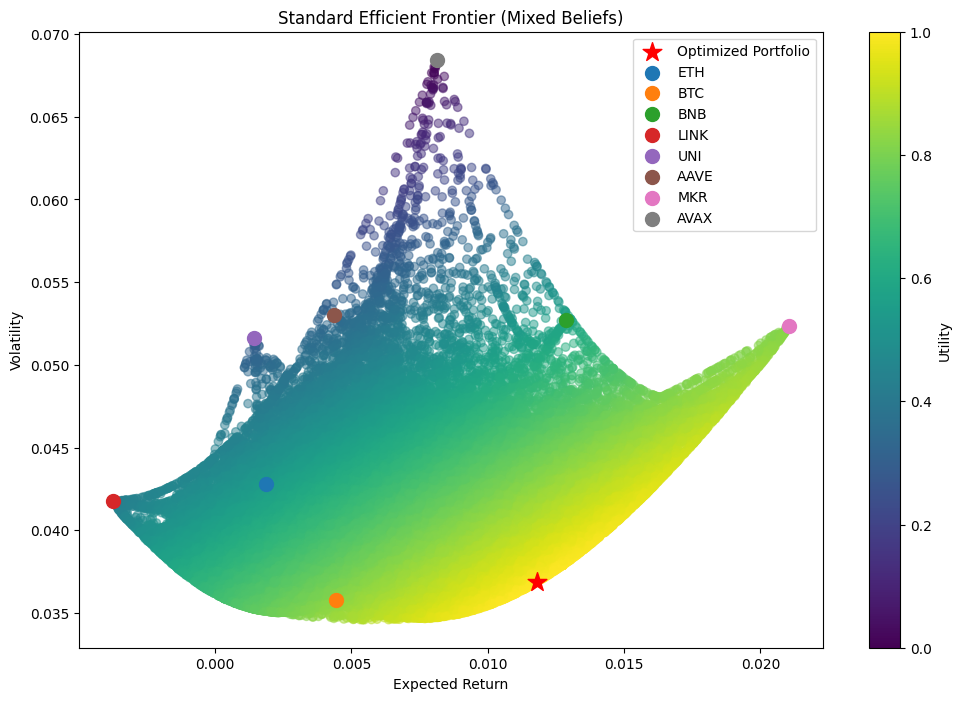

In [20]:
# Generate random portfolios around the efficient frontier
N_per_efficient = 100  # Number of random portfolios per efficient portfolio
expected_returns_close = []
volatilities_close = []

for weights in efficient_portfolios:
    for i in range(N_per_efficient):
        # Add small random noise to weights
        noise = np.random.normal(0, 0.6, len(weights))
        perturbed_weights = weights + noise
        # Ensure weights are between 0 and 1
        perturbed_weights = np.clip(perturbed_weights, 0, 1)
        # Normalize to sum to 1
        perturbed_weights /= np.sum(perturbed_weights)
        # Compute expected return and volatility
        expected_return = portfolio_return(perturbed_weights, beliefs)
        volatility = portfolio_volatility(perturbed_weights, cov_matrix)
        # Append to results
        expected_returns_close.append(expected_return)
        volatilities_close.append(volatility)
        
#For every portfolio, get the utility for the color map
utilities_close = [utility_function(expected_return, volatility) for expected_return, volatility in zip(expected_returns_close, volatilities_close)]

# Plot the efficient frontier and the random portfolios
plt.figure(figsize=(12, 8))

# Plot the random portfolios around the efficient frontier
plt.scatter(expected_returns_close, volatilities_close, c=utilities_close, cmap='viridis', alpha=0.5)

# Plot the efficient frontier, if you want. Pretty messy. 
# plt.plot(frontier_returns, frontier_volatilities, 'gray', linestyle='--', linewidth=3, label='Efficient Frontier')

# Plot the optimized portfolio
plt.scatter(optimal_expected_return, optimal_volatility, c='red', s=200, marker='*', label='Optimized Portfolio')

# Add the individual assets to the plot
for i, asset in enumerate(beliefs.index):
    plt.scatter(beliefs.iloc[i], np.sqrt(cov_matrix.iloc[i, i]),
                marker='o', s=100, label=asset)

plt.xlabel('Expected Return')
plt.ylabel('Volatility')
plt.title('Standard Efficient Frontier (Mixed Beliefs)')
plt.colorbar(label='Utility')
plt.legend(loc='best')

plt.savefig('standard-mixed.png')

plt.show()



# Simulations

In [21]:
from importlib import reload
import MarkowitzLib
reload(MarkowitzLib)
from MarkowitzLib import simulate
import pandas as pd

REBALANCE_PERIOD = 1
PRICE_HISTORY_LENGTH = 30

df = pd.read_csv('test-data/8-asset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

joined_df, return_metrics, risk_metrics = simulate(df, PRICE_HISTORY_LENGTH, REBALANCE_PERIOD, '2022-01-01', threshold=0.002, weight_factor=2)

Computing Weights: 100%|██████████| 1008/1008 [00:14<00:00, 71.79day/s]


In [2]:
return_metrics

{'FINAL_RETURN': 0.039153849691719644,
 'BTC_EXCESS_RETURN': -0.7626404057688938,
 'ETH_EXCESS_RETURN': 0.1346651074587445,
 'BTC_RETURN': 0.8017942554606134,
 'ETH_RETURN': -0.09551125776702485,
 'TX_FEES': 91.18732881807232}

In [3]:
risk_metrics

{'ANNUALIZED_RETURN': 0.13359605220801374,
 'ANNUALIZED_VOLATILITY': 0.4797341785995422,
 'SHARPE_RATIO': 0.23678957488421512,
 'SORTINO_RATIO': 0.31797262940897103,
 'STD_DEV': 0.030220412666481743,
 'MAX_DRAWDOWN': -0.6721655904162209,
 'VAR_95': -0.04758711165621918,
 'CVAR_95': -0.06934840675539217,
 'BETA': 0.9597307972469623,
 'KURTOSIS': 6.745491349375168,
 'SKEWNESS': -0.17218531535953432}

In [4]:
joined_df.to_csv('results-for-paper-standard-mpt.csv')

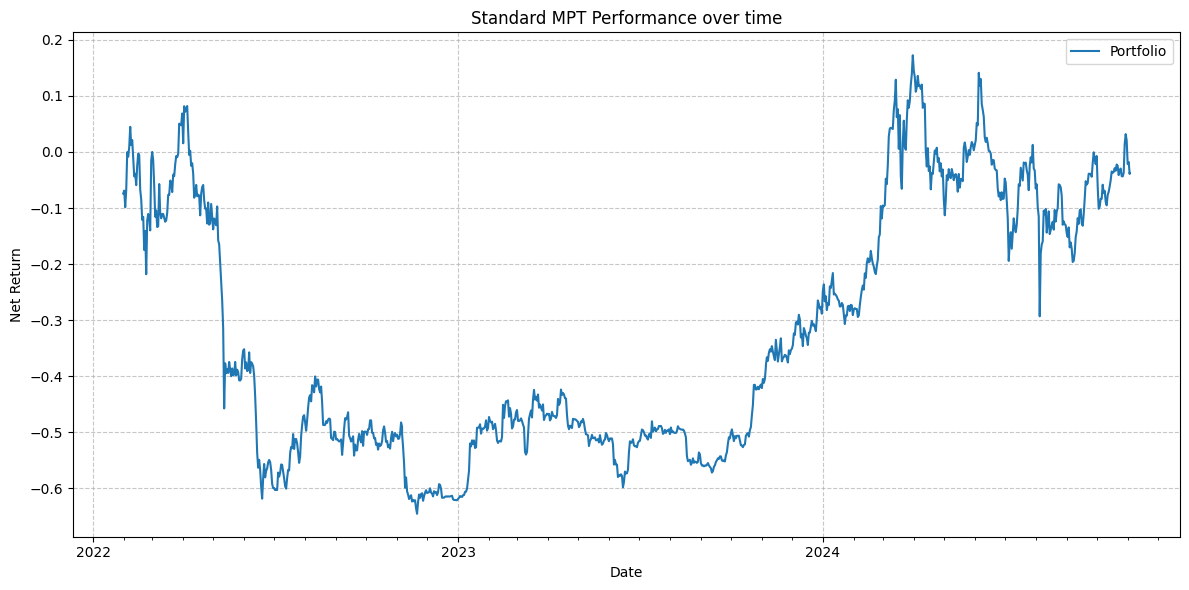

Final Portfolio Net Return: -3.78%


In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Calculate net returns
start_date = '2022-03-01'
start_index = joined_df[joined_df['timestamp'] == start_date].index[0]

portfolio_net_return = (joined_df['PORTFOLIO_VALUE'] / joined_df.loc[start_index, 'PORTFOLIO_VALUE']) - 1
# btc_net_return = (joined_df['BTC_PRICES'] / joined_df.loc[start_index, 'BTC_PRICES']) - 1
# eth_net_return = (joined_df['ETH_PRICES'] / joined_df.loc[start_index, 'ETH_PRICES']) - 1

# Convert timestamp to datetime
joined_df['timestamp'] = pd.to_datetime(joined_df['timestamp'])

# Plot net returns
plt.figure(figsize=(12, 6))
plt.plot(joined_df['timestamp'], portfolio_net_return, label='Portfolio')
# plt.plot(joined_df['timestamp'], btc_net_return, label='BTC')
# plt.plot(joined_df['timestamp'], eth_net_return, label='ETH')

plt.title('Standard MPT Performance over time')
plt.xlabel('Date')
plt.ylabel('Net Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Improve x-axis readability
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# Print final net returns
print(f"Final Portfolio Net Return: {portfolio_net_return.iloc[-1]:.2%}")